In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import division

import numpy as np

import scipy as sp
import scipy.special as sps
import scipy.linalg as sl

import matplotlib
import matplotlib.pyplot as plt

from pylab import figure
from numpy import random

import bilby
import shutil
import corner

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['font.size'] = '20'

In [2]:
def cleanup_dir(outdir):
    # cleanup
    try:
        shutil.rmtree(outdir)
    except OSError as e:
        pass # directory doesn't exist

# I. Simple example comparing frequentist and bayesian CC analyses

# white GWB in white noise in two colocated and coaligned detectors

In [3]:
# segment duration and sampling period
T = 64. # sec 
fS = 8 # Hz
deltaT = 1/fS
N = int(T/deltaT)

In [4]:
# injected values (V for white noise variance)
Vh_true  = 0.3
Vn1_true = 1.   
Vn2_true = 1. 

# auto-correlations
V1_true = Vn1_true + Vh_true
V2_true = Vn2_true + Vh_true

# expected snr
rho = np.sqrt(N) * Vh_true / np.sqrt(V1_true * V2_true) 
print('expected snr =', rho)

expected snr = 5.221711614916043


In [5]:
# prior distributions

# prior ranges
Vh_min = 1.e-6
Vh_max = 1.
Vn1_min = 0.5
Vn1_max = 2.
Vn2_min = 0.5
Vn2_max = 2.

512 63.875 63.875 64.0


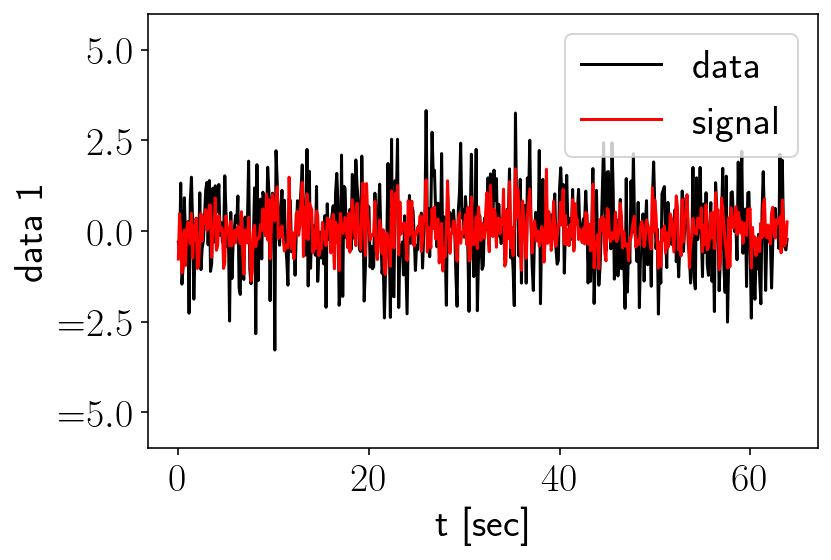

<Figure size 432x288 with 0 Axes>

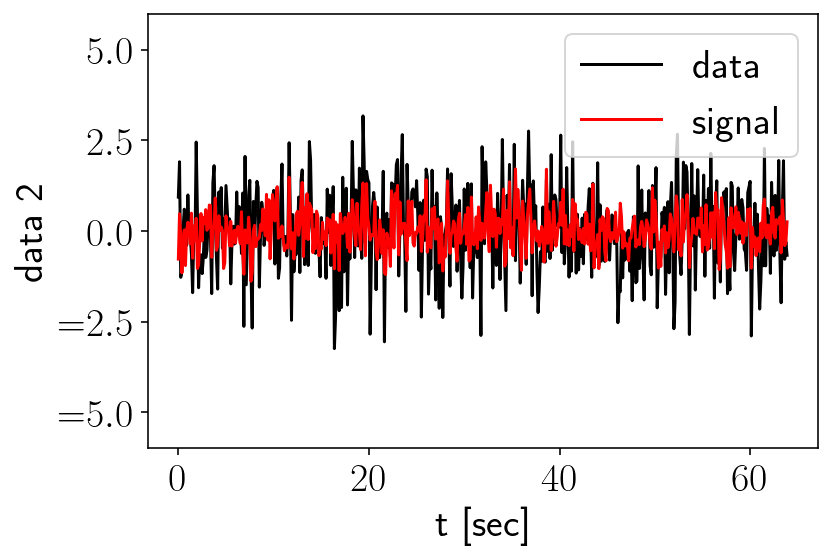

<Figure size 432x288 with 0 Axes>

In [6]:
# simulate data
random.seed(1234)

# discrete times
t = deltaT*np.arange(0, N, 1)
print(len(t), t[-1], T-deltaT, T)

# generate random samples
n1 = random.normal(0, np.sqrt(Vn1_true), N)
n2 = random.normal(0, np.sqrt(Vn2_true), N)
h  = random.normal(0, np.sqrt(Vh_true), N)

# add signal + noise
d1 = n1 + h
d2 = n2 + h

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.plot(t, d1, color='k', label='data')
plt.plot(t, h, linestyle='solid', color='r', label='signal')
plt.xlabel('t [sec]')
plt.ylabel('data 1')
plt.ylim((-6,6))
plt.legend()
plt.show()
plt.savefig('data1.pdf', bbox_inches='tight', dpi=400)


plt.figure()
plt.rc('text', usetex=True)
plt.plot(t, d2, color='k', label='data')
plt.plot(t, h, linestyle='solid', color='r', label='signal')
plt.xlabel('t [sec]')
plt.ylabel('data 2')
plt.ylim((-6,6))
plt.legend()
plt.show()
plt.savefig('data2.pdf', bbox_inches='tight', dpi=400)

# frequentist analysis

In [7]:
# time domain estimators
d11 = np.sum(d1**2)
d22 = np.sum(d2**2)
d12 = np.sum(0.5*(d1*d2 + d2*d1))

# noise only ML estimators
V1_hat = d11/N
V2_hat = d22/N
Vn1_hat_noise_only = V1_hat
Vn2_hat_noise_only = V2_hat

print('Vn1_hat_noise_only =', Vn1_hat_noise_only)
print('Vn2_hat_noise_only =', Vn2_hat_noise_only)

# signal+noise ML estimators
Vh_hat  = d12/N
V1S2_hat = V1_hat*V2_hat
Vn1_hat = V1_hat - Vh_hat
Vn2_hat = V2_hat - Vh_hat
var_Vh_hat = V1_hat*V2_hat/N
snr_Vh_hat = Vh_hat/np.sqrt(var_Vh_hat)

print('\n')
print('Vh_hat =', Vh_hat)
print('V1_hat =', V1_hat)
print('V2_hat =', V2_hat)
print('Vn1_hat =', Vn1_hat)
print('Vn2_hat =', Vn2_hat)
print('var_Vh_hat =', var_Vh_hat)
print('snr_Vh_hat =', snr_Vh_hat)
print('snr^2', snr_Vh_hat**2)

Vn1_hat_noise_only = 1.2206459553063098
Vn2_hat_noise_only = 1.311106221136249


Vh_hat = 0.26601206248000536
V1_hat = 1.2206459553063098
V2_hat = 1.311106221136249
Vn1_hat = 0.9546338928263045
Vn2_hat = 1.0450941586562437
var_Vh_hat = 0.0031257744254041065
snr_Vh_hat = 4.757978920882537
snr^2 22.63836341156255


In [8]:
# ML likelihood ratios
LambdaML = 1.0/(np.sqrt( (1-Vh_hat**2/(V1_hat*V2_hat))**N ))
Lambda = 2*np.log(LambdaML)
Lambda_weak = N*Vh_hat**2/(V1_hat*V2_hat)
                   
print('\nDetection statistic')
print('LambdaML      = ', LambdaML)
print('Lambda        = ', Lambda)
print('Lambda (weak) = ', Lambda_weak)


Detection statistic
LambdaML      =  106622.90498537125
Lambda        =  23.154107272327263
Lambda (weak) =  22.638363411562548


# bayesian analysis

# noise-only likelihood

In [9]:
class GaussianNoiseLikelihoodWhite(bilby.Likelihood):
    def __init__(self, d1, d2):
        """
        white noise, white signal, two coincident and coaligned detectors
        """
        super().__init__(parameters={'Vn1': None, 'Vn2': None})
        self.d1 = d1
        self.d2 = d2
        self.N = len(d1)
        
        # estimators
        self.V1_hat = np.mean(d1*d1)
        self.V2_hat = np.mean(d2*d2)
        
    def log_likelihood(self):
        Vn1 = self.parameters['Vn1']
        Vn2 = self.parameters['Vn2']
                        
        # extract relevant data products
        N = self.N
        V1_hat = self.V1_hat
        V2_hat = self.V2_hat
        
        V1 = Vn1
        V2 = Vn2
        
        beta = V1*V2
        arg = (V1_hat*V2 + V2_hat*V1)/beta
        
        norm = -0.5 * N * (np.log(beta) + 2.0*np.log(2.0*np.pi))
        x    = -0.5 * N * arg
        lnlike = norm + x      
        lnlike = float(lnlike)
        
        return lnlike
    

14:33 bilby INFO    : Running for label 'NoiseWhite', output will be saved to 'outdir'
14:33 bilby INFO    : Search parameters:
14:33 bilby INFO    :   Vn1 = Uniform(minimum=0.5, maximum=2.0, name='$\\sigma^2_{n_1}$', latex_label='$\\sigma^2_{n_1}$', unit=None, boundary=None)
14:33 bilby INFO    :   Vn2 = Uniform(minimum=0.5, maximum=2.0, name='$\\sigma^2_{n_2}$', latex_label='$\\sigma^2_{n_2}$', unit=None, boundary=None)
14:33 bilby INFO    : Single likelihood evaluation took 6.148e-05 s


0it [00:00, ?it/s]

14:33 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x162dfe8b0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
14:33 bilby INFO    : Checkpoint every check_point_delta_t = 600s
14:33 bilby INFO    : Using dynesty version 1.1
14:33 bilby INFO    : Using the bilby-implemented rwalk sample m

14:33 bilby INFO    : Sampling time: 0:00:23.913172
14:33 bilby INFO    : Summary of results:
nsamples: 7347
ln_noise_evidence:    nan
ln_evidence: -1577.373 +/-  0.077
ln_bayes_factor:    nan +/-  0.077



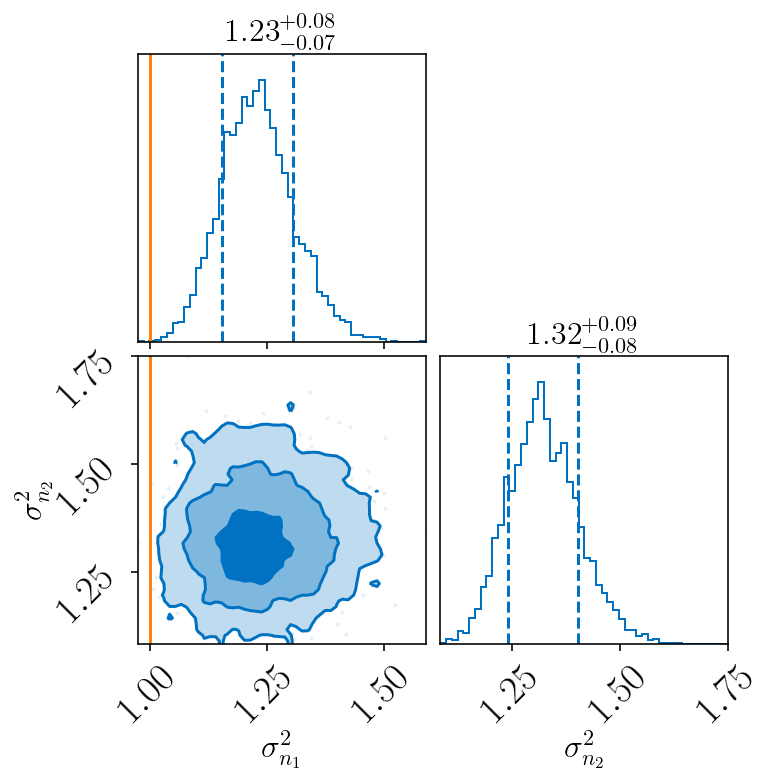

In [10]:
# run likelihood analysis

# A few simple setup steps
label = 'NoiseWhite'
outdir = 'outdir'
cleanup_dir(outdir)

likelihood = GaussianNoiseLikelihoodWhite(d1, d2)
priors = dict(Vn1=bilby.core.prior.Uniform(Vn1_min, Vn1_max, '$\sigma^2_{n_1}$'),
              Vn2=bilby.core.prior.Uniform(Vn2_min, Vn2_max, '$\sigma^2_{n_2}$'))

# Now we define the injection parameters from which we've constructed simulated data
injection_parameters = dict(Vn1=Vn1_true, Vn2=Vn2_true)

# And run sampler
result_noise_white = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=1000,
    injection_parameters = injection_parameters, walks=10, outdir=outdir, label=label)
result_noise_white.plot_corner(filename='cornerplot_noise_white.png')

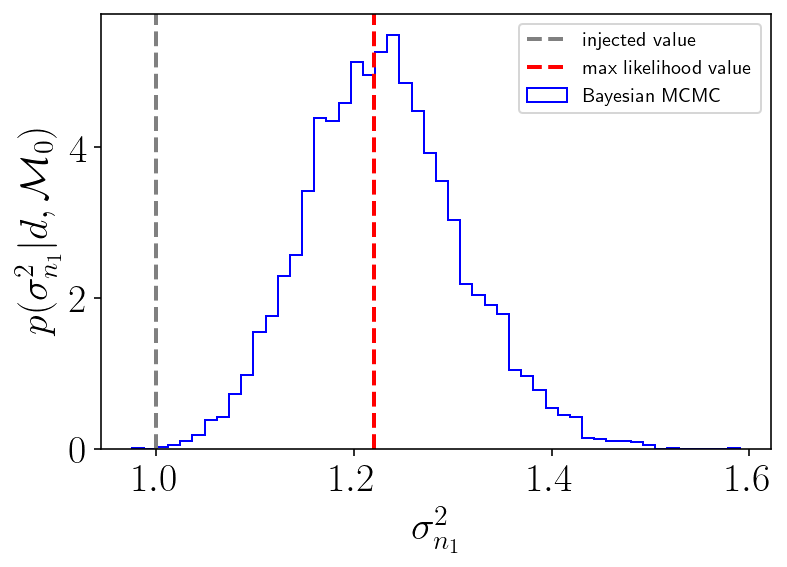

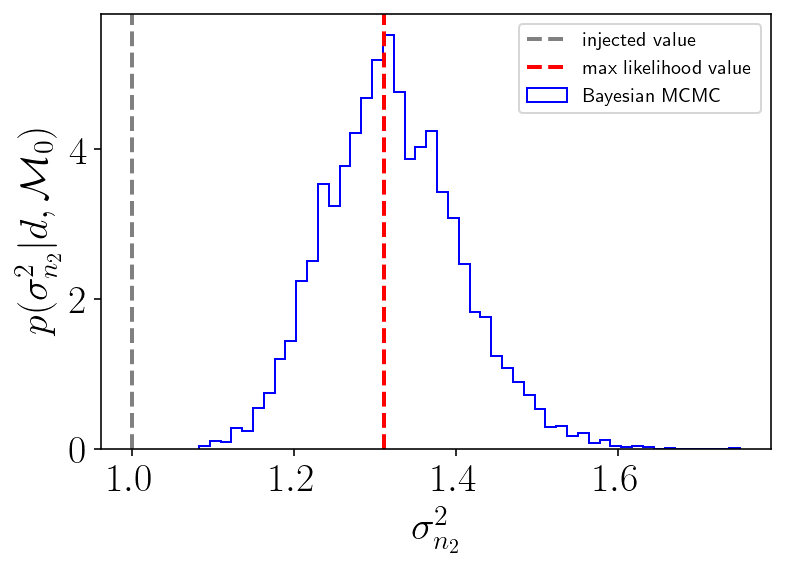

In [11]:
# Vn1
chain_Vn1 = result_noise_white.posterior["Vn1"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Vn1, bins=50, histtype='step', density='true', color='b', label='Bayesian MCMC')
plt.axvline(Vn1_true, color='grey', linewidth=2, linestyle='dashed', label='injected value')
plt.axvline(Vn1_hat_noise_only, color='red', linewidth=2, linestyle='dashed', label='max likelihood value')
plt.xlabel('$\sigma^2_{n_1}$')
plt.ylabel('$p(\sigma^2_{n_1}|d, {\cal M}_0)$')
plt.legend(loc='upper right',fontsize=10)
plt.savefig('postVn1-noise-only.pdf', bbox_inches='tight', dpi=400)

# Vn2
chain_Vn2 = result_noise_white.posterior["Vn2"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Vn2, bins=50, histtype='step', density='true', color='b', label='Bayesian MCMC')
plt.axvline(Vn2_true, color='grey', linewidth=2, linestyle='dashed', label='injected value')
plt.axvline(Vn2_hat_noise_only, color='red', linewidth=2, linestyle='dashed', label='max likelihood value')
plt.xlabel('$\sigma^2_{n_2}$')
plt.ylabel('$p(\sigma^2_{n_2}|d, {\cal M}_0)$')
plt.legend(loc='upper right',fontsize=10)
plt.savefig('postVn2-noise-only.pdf', bbox_inches='tight', dpi=400)

# signal+noise likelihood

In [12]:
class GaussianLikelihoodWhite(bilby.Likelihood):
    def __init__(self, d1, d2):
        """
        white noise, white signal, two coincident and coaligned detectors
        """
        super().__init__(parameters={'Vh': None, 'Vn1': None, 'Vn2': None})
        self.d1 = d1
        self.d2 = d2
        self.N = len(d1)
        
        # estimators
        self.Vh_hat = np.mean(d1*d2)
        self.V1_hat = np.mean(d1*d1)
        self.V2_hat = np.mean(d2*d2)
        
    def log_likelihood(self):
        Vh = self.parameters['Vh']
        Vn1 = self.parameters['Vn1']
        Vn2 = self.parameters['Vn2']
                        
        # extract relevant data products
        N = self.N
        Vh_hat = self.Vh_hat
        V1_hat = self.V1_hat
        V2_hat = self.V2_hat
        
        V1 = Vn1 + Vh
        V2 = Vn2 + Vh
        
        beta = V1*V2 - Vh**2        
        arg = (V1_hat*V2 + V2_hat*V1 - 2*Vh*Vh_hat)/beta
        
        norm = -0.5 * N * (np.log(beta) + 2.0*np.log(2.0*np.pi))
        x    = -0.5 * N * arg
        lnlike = norm + x      
        lnlike = float(lnlike)
        
        return lnlike
    

14:34 bilby INFO    : Running for label 'suffstatTestWhite', output will be saved to 'outdir'
14:34 bilby INFO    : Search parameters:
14:34 bilby INFO    :   Vh = Uniform(minimum=1e-06, maximum=1.0, name='$\\sigma^2_h$', latex_label='$\\sigma^2_h$', unit=None, boundary=None)
14:34 bilby INFO    :   Vn1 = Uniform(minimum=0.5, maximum=2.0, name='$\\sigma^2_{n_1}$', latex_label='$\\sigma^2_{n_1}$', unit=None, boundary=None)
14:34 bilby INFO    :   Vn2 = Uniform(minimum=0.5, maximum=2.0, name='$\\sigma^2_{n_2}$', latex_label='$\\sigma^2_{n_2}$', unit=None, boundary=None)
14:34 bilby INFO    : Single likelihood evaluation took 6.125e-05 s


0it [00:00, ?it/s]

14:34 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x164ace2b0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
14:34 bilby INFO    : Checkpoint every check_point_delta_t = 600s
14:34 bilby INFO    : Using dynesty version 1.1
14:34 bilby INFO    : Using the bilby-implemented rwalk sample m

14:34 bilby INFO    : Sampling time: 0:00:39.530125
14:34 bilby INFO    : Summary of results:
nsamples: 9387
ln_noise_evidence:    nan
ln_evidence: -1567.850 +/-  0.098
ln_bayes_factor:    nan +/-  0.098



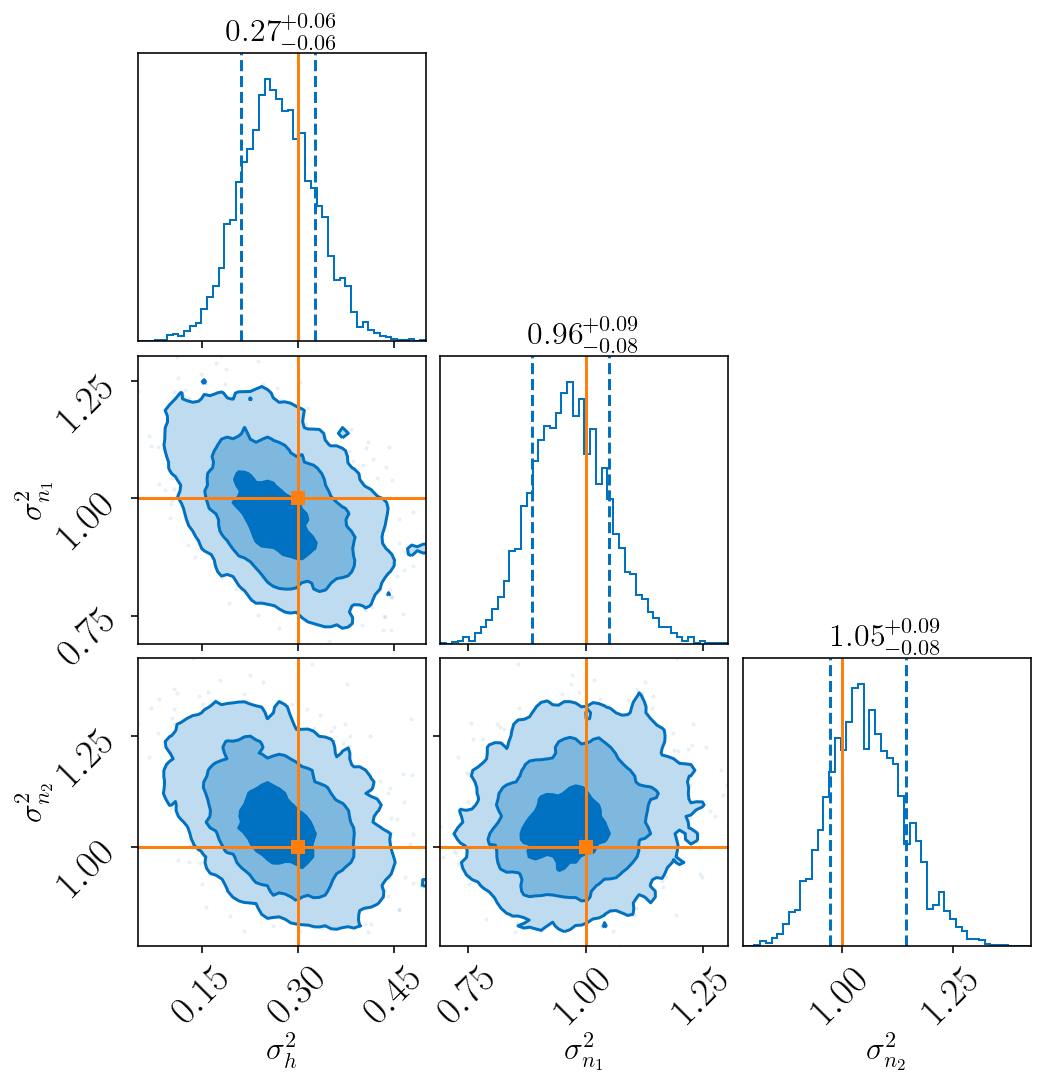

In [13]:
# run likelihood analysis

# A few simple setup steps
label = 'suffstatTestWhite'
outdir = 'outdir'
cleanup_dir(outdir)

likelihood = GaussianLikelihoodWhite(d1, d2)
priors = dict(Vh=bilby.core.prior.Uniform(Vh_min, Vh_max, '$\sigma^2_h$'),
              Vn1=bilby.core.prior.Uniform(Vn1_min, Vn1_max, '$\sigma^2_{n_1}$'),
              Vn2=bilby.core.prior.Uniform(Vn2_min, Vn2_max, '$\sigma^2_{n_2}$'))

# Now we define the injection parameters from which we've constructed simulated data
injection_parameters = dict(Vh=Vh_true, Vn1=Vn1_true, Vn2=Vn2_true)

# And run sampler
result_white = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=1000,
    injection_parameters = injection_parameters, walks=10, outdir=outdir, label=label)
result_white.plot_corner(filename='cornerplot_white.png')

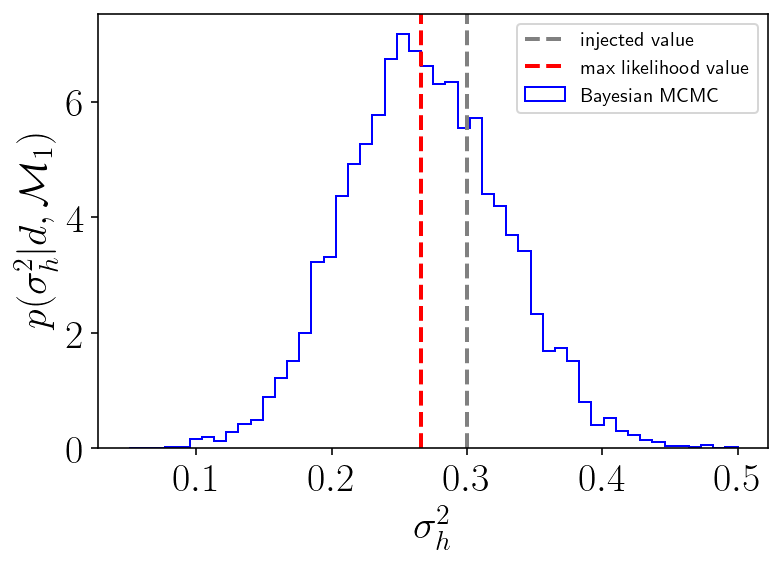

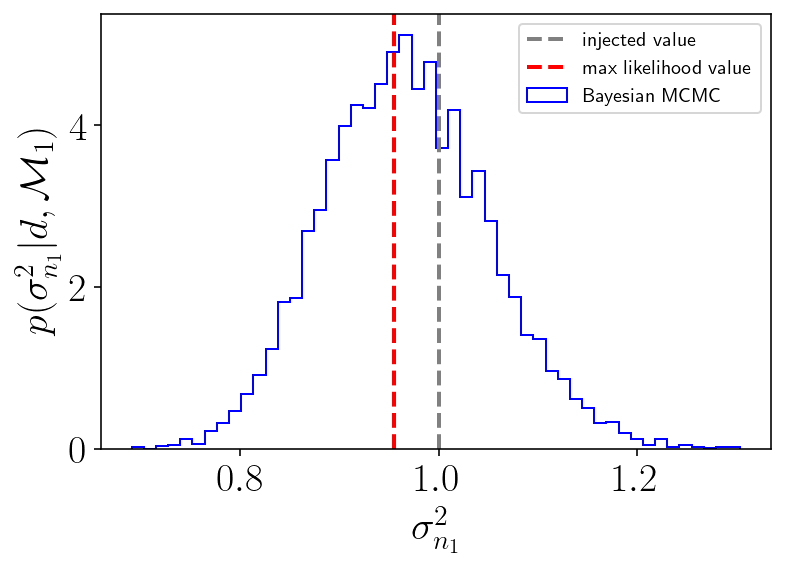

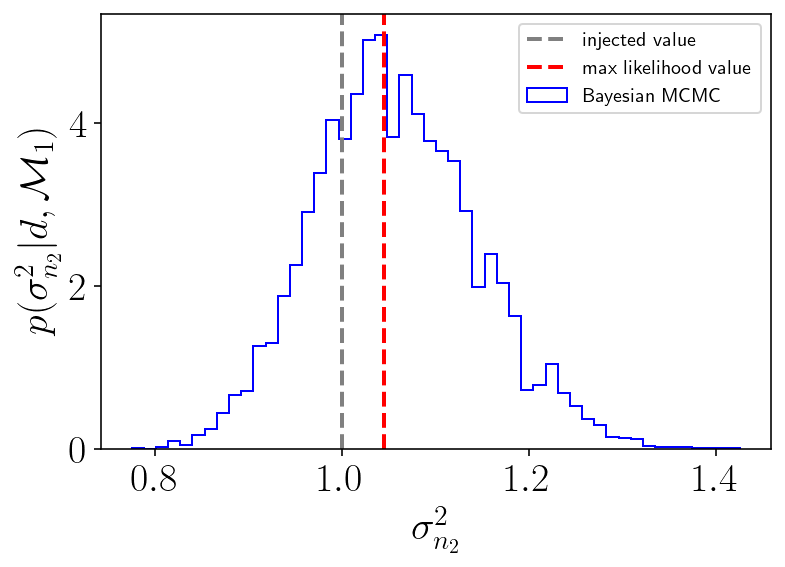

In [14]:
# Sh
chain_Vh = result_white.posterior["Vh"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Vh, bins=50, histtype='step', density='true', color='b', label='Bayesian MCMC')
plt.axvline(Vh_true, color='grey', linewidth=2, linestyle='dashed', label='injected value')
plt.axvline(Vh_hat, color='red', linewidth=2, linestyle='dashed', label='max likelihood value')
plt.xlabel('$\sigma^2_h$')
plt.ylabel('$p(\sigma^2_h|d,{\cal M}_1)$')
plt.legend(loc='upper right',fontsize=10)
plt.savefig('postVh-compare.pdf', bbox_inches='tight', dpi=400)

# Vn1
chain_Vn1 = result_white.posterior["Vn1"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Vn1, bins=50, histtype='step', density='true', color='b', label='Bayesian MCMC')
plt.axvline(Vn1_true, color='grey', linewidth=2, linestyle='dashed', label='injected value')
plt.axvline(Vn1_hat, color='red', linewidth=2, linestyle='dashed', label='max likelihood value')
plt.xlabel('$\sigma^2_{n_1}$')
plt.ylabel('$p(\sigma^2_{n_1}|d,{\cal M}_1)$')
plt.legend(loc='upper right',fontsize=10)
plt.savefig('postVn1-compare.pdf', bbox_inches='tight', dpi=400)

# Vn2
chain_Vn2 = result_white.posterior["Vn2"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Vn2, bins=50, histtype='step', density='true', color='b', label='Bayesian MCMC')
plt.axvline(Vn2_true, color='grey', linewidth=2, linestyle='dashed', label='injected value')
plt.axvline(Vn2_hat, color='red', linewidth=2, linestyle='dashed', label='max likelihood value')
plt.xlabel('$\sigma^2_{n_2}$')
plt.ylabel('$p(\sigma^2_{n_2}|d,{\cal M}_1)$')
plt.legend(loc='upper right',fontsize=10)
plt.savefig('postVn2-compare.pdf', bbox_inches='tight', dpi=400)

# II. cross-correlation searches for stochastic signals

In [15]:
# white gwb in white noise in two detectors
A = 0.1
datafile_det1 = 'whitegwb_in_noise_det1_0.1.txt'
datafile_det2 = 'whitegwb_in_noise_det2_0.1.txt'

noisefile_det1 = 'whitenoise_det1.txt'
noisefile_det2 = 'whitenoise_det2.txt'

signalfile = 'whitenoise.txt'

# extract data
ts = np.loadtxt(datafile_det1)
t = ts[:,0]
d1 = ts[:,1]

ts = np.loadtxt(datafile_det2)
t = ts[:,0]
d2 = ts[:,1]

# extract signal and noise components for comparison
ts = np.loadtxt(signalfile)
s = A*ts[:,1]

ts = np.loadtxt(noisefile_det1)
n1 = ts[:,1]

ts = np.loadtxt(noisefile_det2)
n2 = ts[:,1]

# cross-correlate
N = len(t)
C11 = np.sum(d1**2)/N
C22 = np.sum(d2**2)/N
C12 = np.sum(d1*d2)/N

N11 = np.sum(n1**2)/N
N22 = np.sum(n2**2)/N
gwb = np.sum(s**2)/N

# estimates and SNR calculation
Sh = C12
Sn1 = C11-C12
Sn2 = C22-C12
SNR2 = N*Sh**2/(Sn1*Sn2)
SNR = np.sqrt(SNR2)

print(gwb, N11, N22)
print(Sh, Sn1, Sn2, SNR)
print('\n')

# compare with expected values
deltaT = t[1]-t[0]
pow_meas = 2.*deltaT*Sh
pow_exp  = 2.*deltaT*A**2
percent_error = 100*np.abs(pow_meas-pow_exp)/pow_exp
pow_variance = (2.*deltaT)**2 * Sn1*Sn2/N

print('expected  =', pow_exp)
print('estimated =', pow_meas, '+/-', np.sqrt(pow_variance))
print('range = [', pow_meas-np.sqrt(pow_variance), pow_meas+np.sqrt(pow_variance), ']')
print('percent error =', percent_error)
print('SNR =', pow_meas/np.sqrt(pow_variance))

0.009968179573176044 1.0027613536244697 0.9989182583568834
0.00965249459121984 1.0033269108991112 0.9987759981877667 2.8927143007211527


expected  = 8.888987655418396e-07
estimated = 8.580090526534598e-07 +/- 2.9661036779178587e-07
range = [ 5.613986848616738e-07 1.1546194204452457e-06 ]
percent error = 3.4750540878016216
SNR = 2.8927143007211527


In [16]:
# confusion-limited BNS chirps in white noise in two detectors (N=10, A=0.03)
A = 0.03
datafile_det1 = 'chirpBNS10_in_noise_det1_0.03.txt'
datafile_det2 = 'chirpBNS10_in_noise_det2_0.03.txt'

noisefile_det1 = 'whitenoise_det1.txt'
noisefile_det2 = 'whitenoise_det2.txt'

signalfile = 'chirpBNS10.txt'

# extract data
ts = np.loadtxt(datafile_det1)
t = ts[:,0]
d1 = ts[:,1]

ts = np.loadtxt(datafile_det2)
t = ts[:,0]
d2 = ts[:,1]

# extract signal and noise components for comparison
ts = np.loadtxt(signalfile)
s = A*ts[:,1]

ts = np.loadtxt(noisefile_det1)
n1 = ts[:,1]

ts = np.loadtxt(noisefile_det2)
n2 = ts[:,1]

# cross-correlate
N = len(t)
C11 = np.sum(d1**2)/N
C22 = np.sum(d2**2)/N
C12 = np.sum(d1*d2)/N

N11 = np.sum(n1**2)/N
N22 = np.sum(n2**2)/N
gwb = np.sum(s**2)/N

# estimates and SNR calculation
Sh = C12
Sn1 = C11-C12
Sn2 = C22-C12
SNR2 = N*Sh**2/(Sn1*Sn2)
SNR = np.sqrt(SNR2)

print(gwb, N11, N22)
print(Sh, Sn1, Sn2, SNR)

0.005093198403513448 1.0027613536244697 0.9989182583568834
0.005053407559364201 1.0038746246485857 0.9982282844382919 1.514435936182657


# optimal filtering for cross-correlation search

In [17]:
# white gwb in white noise in two detectors
A = 0.1
datafile_det1 = 'whitegwb_in_noise_det1_0.1.txt'
datafile_det2 = 'whitegwb_in_noise_det2_0.1.txt'

# extract data
ts = np.loadtxt(datafile_det1)
t = ts[:,0]
d1 = ts[:,1]

ts = np.loadtxt(datafile_det2)
t = ts[:,0]
d2 = ts[:,1]

# fourier transform data
deltaT = t[1]-t[0]
d1tilde = deltaT * np.fft.fft(d1)
d2tilde = deltaT * np.fft.fft(d2)

# construct optimal filter
N = len(t)
deltaF = 1/t[-1]
var1 = np.sum(d1**2)/N
var2 = np.sum(d2**2)/N
P1 = 2.*deltaT*var1*np.ones(N) # one-sided
P2 = 2.*deltaT*var2*np.ones(N)
H  = np.ones(N) # unit norm
Q = H/(P1*P2)
norm = 1./((t[-1]/2.)*np.sum(deltaF * pow(H,2)/(P1*P2)))

# do cross-correlation integral
temp = np.sum(deltaF * Q * d1tilde * np.conj(d2tilde))
Y = np.real(temp) # take real part to avoid imaginary round-off
Y = norm*Y

# SNR calculation
sigma2 = 0.5*norm
SNR = Y/np.sqrt(sigma2)

# compare measured with expected amplitude
pow_meas = Y
pow_exp  = 2.*deltaT*A**2
percent_error = 100*np.abs(pow_meas-pow_exp)/pow_exp

print('expected  =', pow_exp)
print('estimated =', pow_meas, '+/-', np.sqrt(sigma2))
print('range = [', pow_meas-np.sqrt(sigma2), pow_meas+np.sqrt(sigma2), ']')
print('percent error =', percent_error)
print('SNR =', SNR)

expected  = 8.888987655418396e-07
estimated = 8.580185861933064e-07 +/- 2.994704052854075e-07
range = [ 5.585481809078989e-07 1.157488991478714e-06 ]
percent error = 3.4739815764857966
SNR = 2.865119794978004


In [18]:
# confusion-limited BNS chirps in white noise in two detectors using optimal filter
A = 0.03
datafile_det1 = 'chirpBNS10_in_noise_det1_0.03.txt'
datafile_det2 = 'chirpBNS10_in_noise_det2_0.03.txt'

# extract data
ts = np.loadtxt(datafile_det1)
t = ts[:,0]
d1 = ts[:,1]

ts = np.loadtxt(datafile_det2)
t = ts[:,0]
d2 = ts[:,1]

# fourier transform data
deltaT = t[1]-t[0]
d1tilde = deltaT * np.fft.fft(d1)
d2tilde = deltaT * np.fft.fft(d2)

# calculate discrete frequencies 
N = len(t)
deltaF = 1.0/(N*deltaT)
fNyq = 1.0/(2*deltaT)
if ( np.mod(N,2)== 0 ):
    numFreqs = int(N/2) - 1
else:
    numFreqs = int((N-1)/2)

# discrete positive frequencies
fp = np.linspace(deltaF, numFreqs*deltaF, numFreqs)

# discrete frequencies (including zero and negative frequencies)
if ( np.mod(N,2)== 0 ):
    a = np.hstack( (np.array([0.]), fp) )
    b = np.hstack( (np.array([-fNyq]), np.flipud(-fp)) )
    f = np.hstack( (a, b) )
else:
    f = np.hstack( (np.hstack(((np.array([0.]),fp))), np.flipud(-fp)) )

# expected signal PSD for chirps
f0 = 100.
H = 1.e-4*np.ones(N)
ndx = np.where(np.abs(f)>=f0)[0]
H[ndx] = 1./pow(np.abs(f[ndx])/f0,7./3.)

# construct optimal filter
var1 = np.sum(d1**2)/N
var2 = np.sum(d2**2)/N
P1 = 2.*deltaT*var1*np.ones(len(d1tilde)) # one-sided
P2 = 2.*deltaT*var2*np.ones(len(d1tilde))
Q = H/(P1*P2)
norm = 1./((t[-1]/2.)*np.sum(deltaF * pow(H,2)/(P1*P2)))

# do cross-correlation integral
temp = np.sum(deltaF * Q * d1tilde * np.conj(d2tilde))
Y = np.real(temp) # take real part to avoid imaginary round-off
Y = norm*Y

# SNR calculation
sigma2 = 0.5*norm
SNR = Y/np.sqrt(sigma2)

# compare measured with expected amplitude
max_power_single_burst = 8.e-3
N_bursts = 10
pow_meas = Y
pow_exp  = max_power_single_burst * N_bursts * A**2
percent_error = 100*np.abs(pow_meas-pow_exp)/pow_exp

print('expected  =', pow_exp)
print('estimated =', pow_meas, '+/-', np.sqrt(sigma2))
print('range = [', pow_meas-np.sqrt(sigma2), pow_meas+np.sqrt(sigma2), ']')
print('percent error =', percent_error)
print('SNR =', SNR)

expected  = 7.2e-05
estimated = 7.396251545888221e-05 +/- 6.068359712322497e-06
range = [ 6.789415574655972e-05 8.00308751712047e-05 ]
percent error = 2.7257159151141774
SNR = 12.188222018001483


In [19]:
# white gwb + confusion-limited BNS chirps in white noise in two detectors (10 chirps, A=0.1, A=0.03)
datafile_det1 = 'whitegwb_chirpBNS10_in_noise_det1.txt'
datafile_det2 = 'whitegwb_chirpBNS10_in_noise_det2.txt'

# extract data
ts = np.loadtxt(datafile_det1)
t = ts[:,0]
d1 = ts[:,1]

ts = np.loadtxt(datafile_det2)
t = ts[:,0]
d2 = ts[:,1]

# fourier transform data
deltaT = t[1]-t[0]
d1tilde = deltaT * np.fft.fft(d1)
d2tilde = deltaT * np.fft.fft(d2)

# construct optimal filter
N = len(t)
deltaF = 1/t[-1]
var1 = np.sum(d1**2)/N
var2 = np.sum(d2**2)/N
P1 = 2.*deltaT*var1*np.ones(N) # one-sided
P2 = 2.*deltaT*var2*np.ones(N)
H  = np.ones(N) # unit norm
Q = H/(P1*P2)
norm = 1./((t[-1]/2.)*np.sum(deltaF * pow(H,2)/(P1*P2)))

# do cross-correlation integral
temp = np.sum(deltaF * Q * d1tilde * np.conj(d2tilde))
Y = np.real(temp) # take real part to avoid imaginary round-off
Y = norm*Y

# SNR calculation
sigma2 = 0.5*norm
SNR = Y/np.sqrt(sigma2)

# compare measured with expected amplitude
A = 0.1
pow_meas = Y
pow_exp  = 2.*deltaT*A**2
percent_error = 100*np.abs(pow_meas-pow_exp)/pow_exp

print('white noise component:')
print('expected  =', pow_exp)
print('estimated =', pow_meas, '+/-', np.sqrt(sigma2))
print('range = [', pow_meas-np.sqrt(sigma2), pow_meas+np.sqrt(sigma2), ']')
print('percent error =', percent_error)
print('SNR =', SNR)
print('  ')

#####################################################
# target confusion-limited BNS chirp component
A = 0.03

# calculate discrete frequencies 
N = len(t)
deltaF = 1.0/(N*deltaT)
fNyq = 1.0/(2*deltaT)
if ( np.mod(N,2)== 0 ):
    numFreqs = int(N/2) - 1
else:
    numFreqs = int((N-1)/2)

# discrete positive frequencies
fp = np.linspace(deltaF, numFreqs*deltaF, numFreqs)

# discrete frequencies (including zero and negative frequencies)
if ( np.mod(N,2)== 0 ):
    a = np.hstack( (np.array([0.]), fp) )
    b = np.hstack( (np.array([-fNyq]), np.flipud(-fp)) )
    f = np.hstack( (a, b) )
else:
    f = np.hstack( (np.hstack(((np.array([0.]),fp))), np.flipud(-fp)) )

# expected signal PSD for chirps
f0 = 100.
H = 1.e-4*np.ones(N)
ndx = np.where(np.abs(f)>=f0)[0]
H[ndx] = 1./pow(np.abs(f[ndx])/f0,7./3.)

# construct optimal filter
var1 = np.sum(d1**2)/N
var2 = np.sum(d2**2)/N
P1 = 2.*deltaT*var1*np.ones(len(d1tilde)) # one-sided
P2 = 2.*deltaT*var2*np.ones(len(d1tilde))
Q = H/(P1*P2)
norm = 1./((t[-1]/2.)*np.sum(deltaF * pow(H,2)/(P1*P2)))

# do cross-correlation integral
temp = np.sum(deltaF * Q * d1tilde * np.conj(d2tilde))
Y = np.real(temp) # take real part to avoid imaginary round-off
Y = norm*Y

# SNR calculation
sigma2 = 0.5*norm
SNR = Y/np.sqrt(sigma2)

# compare measured with expected amplitude
max_power_single_burst = 8.e-3
N_bursts = 10
pow_meas = Y
pow_exp  = max_power_single_burst * N_bursts * A**2
percent_error = 100*np.abs(pow_meas-pow_exp)/pow_exp

print('BNS confusion component:')
print('expected  =', pow_exp)
print('estimated =', pow_meas, '+/-', np.sqrt(sigma2))
print('range = [', pow_meas-np.sqrt(sigma2), pow_meas+np.sqrt(sigma2), ']')
print('percent error =', percent_error)
print('SNR =', SNR)


white noise component:
expected  = 8.888987655418396e-07
estimated = 1.320521015244766e-06 +/- 3.010113498842157e-07
range = [ 1.0195096653605503e-06 1.6215323651289818e-06 ]
percent error = 48.556963563767084
SNR = 4.386947587699619
  
BNS confusion component:
expected  = 7.2e-05
estimated = 7.699029062423081e-05 +/- 6.127475753537914e-06
range = [ 7.08628148706929e-05 8.311776637776872e-05 ]
percent error = 6.930959200320567
SNR = 12.564764630815185


In [20]:
# popcorn BBH chirps, confusion BNS background in white noise in two detectors using optimal filter
A = 0.003
datafile_det1 = 'chirpBNS50BBH10_in_noise_det1_0.003.txt'
datafile_det2 = 'chirpBNS50BBH10_in_noise_det2_0.003.txt'

# extract data
ts = np.loadtxt(datafile_det1)
t = ts[:,0]
d1 = ts[:,1]

ts = np.loadtxt(datafile_det2)
t = ts[:,0]
d2 = ts[:,1]

# fourier transform data
deltaT = t[1]-t[0]
d1tilde = deltaT * np.fft.fft(d1)
d2tilde = deltaT * np.fft.fft(d2)

# calculate discrete frequencies 
N = len(t)
deltaF = 1.0/(N*deltaT)
fNyq = 1.0/(2*deltaT)
if ( np.mod(N,2)== 0 ):
    numFreqs = int(N/2) - 1
else:
    numFreqs = int((N-1)/2)

# discrete positive frequencies
fp = np.linspace(deltaF, numFreqs*deltaF, numFreqs)

# discrete frequencies (including zero and negative frequencies)
if ( np.mod(N,2)== 0 ):
    a = np.hstack( (np.array([0.]), fp) )
    b = np.hstack( (np.array([-fNyq]), np.flipud(-fp)) )
    f = np.hstack( (a, b) )
else:
    f = np.hstack( (np.hstack(((np.array([0.]),fp))), np.flipud(-fp)) )

# expected signal PSD for chirps
f0 = 100.
H = 1.e-4*np.ones(N)
ndx = np.where(np.abs(f)>=f0)[0]
H[ndx] = 1./pow(np.abs(f[ndx])/f0,7./3.)

# construct optimal filter
var1 = np.sum(d1**2)/N
var2 = np.sum(d2**2)/N
P1 = 2.*deltaT*var1*np.ones(len(d1tilde)) # one-sided
P2 = 2.*deltaT*var2*np.ones(len(d1tilde))
Q = H/(P1*P2)
norm = 1./((t[-1]/2.)*np.sum(deltaF * pow(H,2)/(P1*P2)))

# do cross-correlation integral
temp = np.sum(deltaF * Q * d1tilde * np.conj(d2tilde))
Y = np.real(temp) # take real part to avoid imaginary round-off
Y = norm*Y

# SNR calculation
sigma2 = 0.5*norm
SNR = Y/np.sqrt(sigma2)

# compare measured with expected amplitude
max_power_single_burst = 1.
N_bursts = 10
pow_meas = Y
pow_exp  = max_power_single_burst * N_bursts * A**2
percent_error = 100*np.abs(pow_meas-pow_exp)/pow_exp

print('expected  =', pow_exp)
print('estimated =', pow_meas, '+/-', np.sqrt(sigma2))
print('range = [', pow_meas-np.sqrt(sigma2), pow_meas+np.sqrt(sigma2), ']')
print('percent error =', percent_error)
print('SNR =', SNR)

expected  = 9e-05
estimated = 3.385000581761212e-05 +/- 3.827727661413423e-06
range = [ 3.00222781561987e-05 3.767773347902555e-05 ]
percent error = 62.38888242487542
SNR = 8.843368392910351


# component separation method

In [21]:
# component separation method

# white gwb + confusion-limited BNS chirps in white noise in two detectors (10 chirps, A=0.1, A=0.03)
datafile_det1 = 'whitegwb_chirpBNS10_in_noise_det1.txt'
datafile_det2 = 'whitegwb_chirpBNS10_in_noise_det2.txt'

# extract data
ts = np.loadtxt(datafile_det1)
t = ts[:,0]
d1 = ts[:,1]

ts = np.loadtxt(datafile_det2)
t = ts[:,0]
d2 = ts[:,1]

# fourier transform data
deltaT = t[1]-t[0]
d1tilde = deltaT * np.fft.fft(d1)
d2tilde = deltaT * np.fft.fft(d2)
D = (2./t[-1]) * d1tilde * np.conj(d2tilde)

# calculate discrete frequencies 
N = len(t)
deltaF = 1.0/(N*deltaT)
fNyq = 1.0/(2*deltaT)
if ( np.mod(N,2)== 0 ):
    numFreqs = int(N/2) - 1
else:
    numFreqs = int((N-1)/2)

# discrete positive frequencies
fp = np.linspace(deltaF, numFreqs*deltaF, numFreqs)

# discrete frequencies (including zero and negative frequencies)
if ( np.mod(N,2)== 0 ):
    a = np.hstack( (np.array([0.]), fp) )
    b = np.hstack( (np.array([-fNyq]), np.flipud(-fp)) )
    f = np.hstack( (a, b) )
else:
    f = np.hstack( (np.hstack(((np.array([0.]),fp))), np.flipud(-fp)) )

# construct noise covariance matrix
N = len(t)
deltaF = 1/t[-1]
var1 = np.sum(d1**2)/N
var2 = np.sum(d2**2)/N
P1 = 2.*deltaT*var1*np.ones(N) # one-sided
P2 = 2.*deltaT*var2*np.ones(N)
N12 = P1 * P2
invN = 1./N12

# construct optimal filters for components 1 and 2
H1 = np.ones(N) # unit norm
M1 = H1 # overlap function = 1 for this example

# expected signal PSD for chirps
f0 = 100.
H2 = 1.e-4*np.ones(N)
ndx = np.where(np.abs(f)>=f0)[0]
H2[ndx] = 1./pow(np.abs(f[ndx])/f0,7./3.)
M2 = H2 # overlap function = 1 for this example

# do cross-correlation integral for component #1
temp = np.sum(deltaF * M1 * invN * D)
X1 = np.real(temp) # take real part to avoid imaginary round-off

# do cross-correlation integral for component #2
temp = np.sum(deltaF * M2 * invN * D)
X2 = np.real(temp) # take real part to avoid imaginary round-off
#print "X =", X1, X2

# calculate the fisher matrix
F11 = np.real(np.sum(deltaF * M1 * M1 * invN))
F12 = np.real(np.sum(deltaF * M1 * M2 * invN))
F21 = np.real(np.sum(deltaF * M2 * M1 * invN))
F22 = np.real(np.sum(deltaF * M2 * M2 * invN))
#print "F =", F11, F12, F21, F22

# calculate inverse fisher matrix
detF = F11*F22-F12*F21
              
invF11 =  (1./detF)*F22
invF12 = -(1./detF)*F12
invF21 = -(1./detF)*F21
invF22 =  (1./detF)*F11
#print "invF =", invF11, invF12, invF21, invF22

# calculate ML estimator of the two components
Y1 = invF11*X1 + invF12*X2
Y2 = invF21*X1 + invF22*X2
#print "Y =", Y1, Y2

# uncertainties
sigma1 = np.sqrt(invF11)
sigma2 = np.sqrt(invF22)

# compare ML values with expected values of the power
# white noise
A1 = 0.1
expY1  = 2.*deltaT*A1**2
percent_error1 = 100*np.abs(Y1-expY1)/expY1
SNR1 = Y1/sigma1

# BNS confusion
A2 = 0.03
max_power_single_burst = 8.e-3
N_bursts = 10
expY2  = max_power_single_burst * N_bursts * A2**2
percent_error2 = 100*np.abs(Y2-expY2)/expY2
SNR2 = Y2/sigma2

print('white noise component:')
print('expected  =', expY1)
print('estimated =', Y1, '+/-', sigma1)
print('range = [', Y1-sigma1, Y1+sigma1, ']')
print('percent error =', percent_error1)
print('SNR =', SNR1)
print(' ')

print('BNS confusion component:')
print('expected  =', expY2)
print('estimated =', Y2, '+/-', sigma2)
print('range = [', Y2-sigma2, Y2+sigma2, ']')
print('percent error =', percent_error2)
print('SNR =', SNR2)


white noise component:
expected  = 8.888987655418396e-07
estimated = 8.240450495567038e-07 +/- 6.076059881006526e-07
range = [ 2.164390614560512e-07 1.4316510376573564e-06 ]
percent error = 7.29596198118279
SNR = 1.356216142853742
 
BNS confusion component:
expected  = 7.2e-05
estimated = 7.47214902040406e-05 +/- 1.2368537855224252e-05
range = [ 6.235295234881635e-05 8.709002805926485e-05 ]
percent error = 3.7798475056119414
SNR = 6.041254922664894
